In [27]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

生成数据集
生成一个包含1000个样本的数据集，每个样本包含从标准正态分布中采样的两个特征。合成的数据集是一个1000×2的矩阵 线性模型参数w=[2,-3,4] b=4.2和噪声项

In [28]:
def synthetic_data(w, b, num_examples):  #@save
    """生成 y = Xw + b + 噪声。"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

feature中每一行都包含一个二维数据样本，labels中的每一行都包含一个一维标签值

In [29]:
print('features:',features[0],'\nlabels:',labels[0])

features: tensor([0.6681, 1.8534]) 
labels: tensor([-0.7626])


通过生成第二个特征和labels的散点图可以观察到两者的线性关系

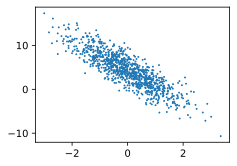

In [30]:
d2l.set_figsize()
d2l.plt.scatter(features[:,1].detach().numpy(),labels.detach().numpy(),1)

读取数据集
在下面的代码中，我们定义一个data_iter函数， 该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量。每个小批量包含一组特征和标签。

In [31]:
def data_iter(batch_size,features,labels):
    num_examples = len(features)
    indices =list(range(num_examples))
    #样本随机读取，没有特定的顺序shuffle函数就是打乱列表的顺序不可以把
    #随机排列的结果复制给一个新的列表变量
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        #意思是从打乱后的索引中连续选取batch_size个然后供给下面返回
        #这个张量里面的索引序号是几号 就会按照索引拿出几号
        batch_indices=torch.tensor(
            indices[i:min(i+batch_size,num_examples)]
        )
        #yield是一个迭代的功能每次执行完之后程序结束 当下次用到该程序时
        #会从上次结束的地方开始继续执行
        yield features[batch_indices],labels[batch_indices]

In [32]:
batch_size=9


for X,y in data_iter(batch_size,features,labels):
    print(X,'\n',y)
    break

tensor([[-0.0952,  2.4855],
        [-0.8306, -1.9063],
        [-0.1347,  1.7761],
        [-2.1337,  0.3439],
        [-0.0983,  0.7601],
        [-1.3919, -0.0579],
        [ 0.1406,  2.1245],
        [-0.5360, -0.2262],
        [-1.3961, -0.3440]]) 
 tensor([[-4.4431],
        [ 9.0264],
        [-2.1058],
        [-1.2393],
        [ 1.4103],
        [ 1.6187],
        [-2.7644],
        [ 3.9116],
        [ 2.5758]])


初始化模型参数
在我们开始用小批量随机梯度下降优化我们的模型参数之前，我们需要先有一些参数。 在下面的代码中，我们通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重，并将偏置初始化为0。

In [42]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
"""在初始化参数之后，我们的任务是更新这些参数，直到这些参数足够拟合我们的
数据。 每次更新都需要计算损失函数关于模型参数的梯度。
有了这个梯度，我们就可以向减小损失的方向更新每个参数。 
因为手动计算梯度很枯燥而且容易出错，所以没有人会手动计算梯度。"""


'在初始化参数之后，我们的任务是更新这些参数，直到这些参数足够拟合我们的\n数据。 每次更新都需要计算损失函数关于模型参数的梯度。\n有了这个梯度，我们就可以向减小损失的方向更新每个参数。 \n因为手动计算梯度很枯燥而且容易出错，所以没有人会手动计算梯度。'

定义模型
接下来，我们必须定义模型，将模型的输入和参数同模型的输出关联起来。 回想一下，要计算线性模型的输出，我们只需计算输入特征 X 和模型权重 w 的矩阵-向量乘法后加上偏置 b 。注意，上面的 Xw 是一个向量，而 b 是一个标量。

In [34]:
def linreg(X,w,b):
    return torch.matmul(X,w)+b

因为要更新模型。需要计算损失函数的梯度，所以我们应该先定义损失函数。 在实现中，我们需要将真实值y的形状转换为和预测值y_hat的形状相同。

In [35]:
def squared_loss(y_hat, y):  
    return (y_hat - y.reshape(y_hat.shape))**2/2

定义优化算法

在每一步中，使用从数据集中随机抽取的一个小批量，然后根据参数计算损失的梯度。接下来，朝着减少损失的方向更新我们的参数。 下面的函数实现小批量随机梯度下降更新。该函数接受模型参数集合、学习速率和批量大小作为输入。每一步更新的大小由学习速率lr决定。 因为我们计算的损失是一个批量样本的总和，所以我们用批量大小（batch_size）来归一化步长，这样步长大小就不会取决于我们对批量大小的选择。

In [36]:
def sgd(params,lr,batch_size):
    #小批量随机梯度下降
    with torch.no_grad():
        for param in params:
            param -= lr*param.grad/batch_size
            param.grad.zero_()

训练

In [43]:
lr =0.03
num_epochs =3
net =linreg
loss =squared_loss
for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        #计算X和y的小批量损失
        l =loss(net(X,w,b),y)
        #因为l的形状是(batch_xize,1)所以需要l中所有元素加到一其并且以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w,b],lr,batch_size)#使用参数的梯度更新参数
    with torch.no_grad():
        train_l =loss(net(features,w,b),labels)
    print(w)
    print(f'epoch{epoch+1},loss{float(train_l.mean()):f}')

tensor([[ 1.9503],
        [-3.2956]], requires_grad=True)
epoch1,loss0.015606
tensor([[ 1.9991],
        [-3.3969]], requires_grad=True)
epoch2,loss0.000062
tensor([[ 1.9997],
        [-3.3994]], requires_grad=True)
epoch3,loss0.000048


由于我们使用的是自己的数据集，所以我们知道真正的参数是什么。因此可以通过比较预测参数和真实参数来得知训练的成功程度。

In [44]:
print(f'w的估计误差：{true_w-w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b-b}')

w的估计误差：tensor([ 0.0003, -0.0006], grad_fn=<SubBackward0>)
b的估计误差：tensor([-0.0001], grad_fn=<RsubBackward1>)
